<a href="https://colab.research.google.com/github/byui-cse/cse380-notebooks/blob/master/12_4_About_Nondeterministic_Finite_Automata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About Nondeterministic Finite Automata
## 24 March 2021

## The Idea of Nondeterminism

Nondeterminism essentially means determinism is out the window, and the ramifications of this are twofold:

1. Nondeterministic Finite Automata (NFA) are easier to deal with in some ways, and harder in others, than Deterministic Finite Automata (DFA). Rather than having a single state to transition to on a given input character, there can be two or more possibilities. And that opening up of possibilities means...
2. There is power in being able to postpone decisions --- in other words, keep multiple options open.

To see one advantage of nondeterminism, consider the exponential explosion in the number of states that you saw with the language family:

$L_k = \{x0z\ \mid\ x \in \{0, 1\}^*, z \in \{0, 1\}^k\}$

Or, using Regular Expressions with $+$ meaning $\cup$, for $k = 0, 1, 2, 3, \ldots$

* $k = 0: (0+1)^*0$
* $k = 1: (0+1)^*0(0+1)$
* $k = 2: (0+1)^*0(0+1)(0+1)$
* $k = 3: (0+1)^*0(0+1)(0+1)(0+1)$
* $\cdots$

As you discovered, defining DFA (parameterized on $k$) that recognize this language family is **not** easy.

See the graphs [of minimal DFA!](https://rickneff.github.io/non-determinism-to-determinism-cost.pdf).

See also elegantly symmetrical hand-drawn equivalents of DFA recognizing $L_1, L_2,$ and $L_3$ at [nth last 0 with a twist](https://rickneff.github.io/images/nth-last-0-with-a-twist.jpg).

## With NFA

... it is **super** easy!

We'll draw them this time without the "empty" (invisible) state and just stipulate that the leftmost state is the start state.

### $L_0$

In [3]:
from graphviz import Source

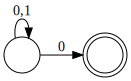

In [4]:
last_bit_zero = '''
digraph {
  rankdir="LR"
  node [shape=circle]
  S0 [label=""]
  S1 [shape=doublecircle, label=""]

  S0 -> S0 [label="0,1"]
  S0 -> S1 [label=0]
}
'''
Source(last_bit_zero)

### $L_1$

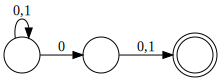

In [5]:
second_to_last_bit_zero = '''
digraph {
  rankdir="LR"
  node [shape=circle]
  S0 [label=""]
  S1 [label=""]
  S2 [shape=doublecircle, label=""]

  S0 -> S0 [label="0,1"]
  S0 -> S1 [label=0]
  S1 -> S2 [label="0,1"]
}
'''
Source(second_to_last_bit_zero)

### $L_2$

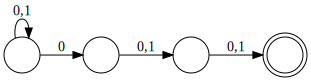

In [6]:
third_to_last_bit_zero = '''
digraph {
  rankdir="LR"
  node [shape=circle]
  S0 [label=""]
  S1 [label=""]
  S2 [label=""]
  S3 [shape=doublecircle, label=""]

  S0 -> S0 [label="0,1"]
  S0 -> S1 [label=0]
  S1 -> S2 [label="0,1"]
  S2 -> S3 [label="0,1"]
}
'''
Source(third_to_last_bit_zero)

### $L_3$

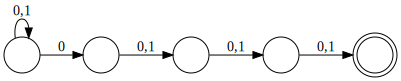

In [7]:
fourth_to_last_bit_zero = '''
digraph {
  rankdir="LR"
  node [shape=circle]
  S0 [label=""]
  S1 [label=""]
  S2 [label=""]
  S3 [label=""]
  S4 [shape=doublecircle, label=""]

  S0 -> S0 [label="0,1"]
  S0 -> S1 [label=0]
  S1 -> S2 [label="0,1"]
  S2 -> S3 [label="0,1"]
  S3 -> S4 [label="0,1"]
}
'''
Source(fourth_to_last_bit_zero)

## The Effect of Nondeterminism

... on automaton operations is striking, particularly its use for describing regular languages.

The presence of nondeterminism affects the ease with which certain automaton operations can be carried out.

1. The operations of *union*, *concatenation*, and *star* become **easier** to preform.
2. The operations of *complementation*, *intersection*, and *equivalence* become **harder** to perform.

A video made by Professor Ganesh Gopalakrishnan as he demonstrates the "Jove" tools is available. Watch it on YouTube [here](https://www.youtube.com/watch?v=eRiLkERXNwE&feature=youtu.be) or by executing the code block below.

Start around the 37th minute, thus skipping some information normally treated in DM4 (CSE 480).

Around 47:30 is where Ganesh formally explains what NFA are and how they behave.

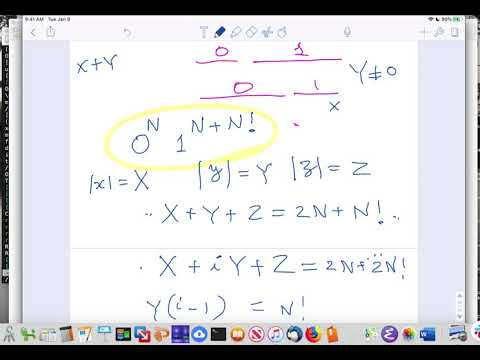

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('eRiLkERXNwE')

In [9]:
!cat Jove/jove/Def_NFA.py

cat: Jove/jove/Def_NFA.py: No such file or directory


## Try it with Threads

In [10]:
from threading import Thread

class NFA(Thread):
  def __init__(self, input, next_input_index, history,
               current_state, next_state_dict):
    super().__init__()
    self.input = input
    self.next_input_index = next_input_index
    self.history = history
    self.current_state = current_state
    self.next_state_dict = next_state_dict
    super().start()

  def run(self):
    while self.has_more_input():
      self.consume_input()
    self.return_and_report()   

  def has_more_input(self):
    return self.next_input_index < len(self.input)
  
  def consume_input(self):
    next_symbol = self.input[self.next_input_index]
    # handle transitions on next_symbol if any
    key = (self.current_state, next_symbol)
    if key in self.next_state_dict:
      next_states = self.next_state_dict[key]
      for next_state in next_states:
        NFA(self.input, self.next_input_index + 1,
            self.history + '--' + next_symbol + '-->' + next_state,
            next_state, self.next_state_dict)
    # handle "empty string" transitions
    next_symbol = ''
    key = (self.current_state, next_symbol)
    if key in self.next_state_dict:
      next_states = self.next_state_dict[key]
      for next_state in next_states:
        NFA(self.input, self.next_input_index, # NOTE: no "+ 1"
            self.history + '---->' + next_state,
            next_state, self.next_state_dict)
    self.stop()

  def stop(self):
    """Force exit from while loop in run for this machine,
       all remaining input will be consumed by the
       "forked copies", if any.
    """
    self.input = ''

  def is_in_final_state(self):
    """By convention, final states have 'F' in their name.
    """
    return self.current_state.count('F')

  def return_and_report(self):
    self.history += (', final state, so ACCEPT.'
      if self.is_in_final_state() 
      else ', NOT a final state, so REJECT.')
    print(self.history if self.input else '', flush=True)

In [11]:
NFA('00', 0, 'I', 'I',
    {('I', ''): {'F1', 'F2'},
     ('F1', '0'): {'B'},
     ('F2', '0'): {'C'},
     ('B', '0'): {'F1'},
     ('C', '0'): {'D'},
     ('D', '0'): {'F2'}});


I---->F2--0-->C--0-->D, NOT a final state, so REJECT.


I---->F1--0-->B--0-->F1, final state, so ACCEPT.




## Try it with Jove

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import sys

# -- Detect if in Own Install or in Colab
try:
    import google.colab
    OWN_INSTALL = False
except:
    OWN_INSTALL = True
    
if OWN_INSTALL:
  
  sys.path[0:0] = ['../../../../..',  '../../../../../3rdparty',  
                   '../../../..',  '../../../../3rdparty',  
                   '../../..',     '../../../3rdparty', 
                   '../..',        '../../3rdparty',
                   '..',           '../3rdparty',
                   '../Jove',      '../Jove/jove']

else: # In colab
  ! if [ ! -d Jove ]; then git clone https://github.com/ganeshutah/Jove Jove; fi
  sys.path.append('./Jove')
  sys.path.append('./Jove/jove')

# -- common imports --
from jove.DotBashers import *
from jove.Def_md2mc  import *
from jove.Def_NFA    import *
from jove.Def_DFA    import *
from jove.Def_NFA2RE import *
from jove.Def_RE2NFA import *
from jove.AnimateNFA import *
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ModuleNotFoundError: No module named 'jove'

In [ ]:
nfa = md2mc("""
 NFA 
   I: '' -> F1,F2
  F1: 0 -> B
   B: 0 -> F1 
  F2: 0 -> C
   C: 0 -> D
   D: 0 -> F2
""")

In [ ]:
nfa

In [ ]:
dotObj_dfa(min_dfa(nfa2dfa(nfa)))

In [ ]:
dotObj_nfa(nfa)

In [ ]:
AnimateNFA(nfa)
display(HTML('<link rel=\"stylesheet\" href=\"//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css\"/>'))

To see more of what Jove can do, [go here](https://colab.research.google.com/github/ganeshutah/Jove/blob/master/For_The_Public/SIGCSE21/SIGCSE_2021_Demo_of_Jove.ipynb).